# DA6401- Deep Learning with Convolutional Neural Networks Part A


## Aravindan Kamatchi Sundaram MM21B010

## Setting up WandB environment and loading the dataset

In [ ]:
%pip install -q wandb
import wandb
wandb.login(relogin=True, key="011c3a6cd3743b4b10442ed458038feb25f78ad6")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/inaturalist_12K/train" "/content/train"

Defining the model class for flexible CNN training.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class FlexibleCNN(nn.Module):
#     def __init__(self, input_channels, num_classes=10, conv_filters=[32]*5, filter_size=3,
#                  activation='ReLU', dense_units=128, dropout_rate=0.5, input_size=224):
#         super(FlexibleCNN, self).__init__()

#         activations = {
#             'ReLU': nn.ReLU(),
#             'GELU': nn.GELU(),
#             'SiLU': nn.SiLU(),
#             'Mish': nn.Mish()
#         }

#         self.activation_fn = activations[activation]
#         self.conv_layers = nn.ModuleList()

#         in_channels = input_channels
#         for out_channels in conv_filters:
#             self.conv_layers.append(
#                 nn.Sequential(
#                     nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=1),
#                     self.activation_fn,
#                     nn.MaxPool2d(kernel_size=2)
#                 )
#             )
#             in_channels = out_channels

#         with torch.no_grad():
#             dummy_input = torch.zeros(1, input_channels, input_size, input_size)
#             x = dummy_input
#             for layer in self.conv_layers:
#                 x = layer(x)
#             self.flattened_size = x.view(1, -1).size(1)

#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(self.flattened_size, dense_units)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(dense_units, num_classes)

#     def forward(self, x):
#         for conv in self.conv_layers:
#             x = conv(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

class FlexibleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10,
                        conv_filters=[16, 32, 64, 128, 256],
                        conv_kernel_size=3,
                        conv_activation=nn.ReLU(),
                        use_batchnorm=False,
                        dropout_rate=0.0,
                        dense_neurons=128,
                        dense_activation=nn.ReLU()):
        super(FlexibleCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        if isinstance(conv_kernel_size, int):
            conv_kernel_size = [conv_kernel_size] * 5
        elif len(conv_kernel_size) != 5:
            raise ValueError("conv_kernel_size must be an integer or a list of 5 integers.")

        in_c = in_channels
        for i in range(5):
            out_c = conv_filters[i]
            kernel_size = conv_kernel_size[i]
            layers = [nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=kernel_size // 2)]
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(conv_activation)
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            if dropout_rate > 0 and i < 4:
                layers.append(nn.Dropout(dropout_rate))
            self.conv_layers.extend(layers)
            in_c = out_c

        self._to_linear = None
        self._determine_linear_input_size((1, in_channels, 224, 224))

        self.dense1 = nn.Linear(self._to_linear, dense_neurons)
        self.dense_activation = dense_activation
        if dropout_rate > 0:
            self.dropout_dense = nn.Dropout(dropout_rate)
        else:
            self.dropout_dense = nn.Identity()
        self.fc = nn.Linear(dense_neurons, num_classes)

    def _determine_linear_input_size(self, input_shape):
        x = torch.randn(input_shape)
        self.eval()
        with torch.no_grad():
            for layer in self.conv_layers:
                x = layer(x)
            self._to_linear = x.view(x.size(0), -1).shape[1]
        self.train()

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_dense(x)
        x = self.dense1(x)
        x = self.dense_activation(x)
        x = self.fc(x)
        return x

Initializing and defining loaders for loading the dataset

In [ ]:
import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

def load_data(data_dir, val_split=0.2, batch_size=64, augment=False):
    # Transform without augmentation (used for validation)
    base_transform = [transforms.Resize((224, 224))]
    if augment:
        base_transform.append(transforms.RandomHorizontalFlip())
    base_transform.append(transforms.ToTensor())
    transform_train = transforms.Compose(base_transform)
    transform_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Use a basic transform initially to get labels and split
    split_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    full_dataset = ImageFolder(root=os.path.join(data_dir, "train"), transform=split_transform)

    # Get labels for stratified split
    targets = [sample[1] for sample in full_dataset.samples]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=42)
    train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

    # Assign transforms post split
    full_dataset.transform = transform_train
    train_dataset = Subset(full_dataset, train_idx)

    val_dataset = Subset(ImageFolder(root=os.path.join(data_dir, "train"), transform=transform_val), val_idx)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, full_dataset.classes


In [ ]:
from torchvision import transforms, datasets
# Short-form data loading (inside train function)
data_dir = r"C:\Users\arvin\Downloads\nature_12K\inaturalist_12K\train"
data_dir = '/content/drive/MyDrive/nature_12K/inaturalist_12K/train'
data_dir="/content/train"
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split into train/val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

Training the CNN and logging detials into WandB for analysis.

In [ ]:
from tqdm import trange

def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb.run.name = f"dr_{config.dropout}_bs_{config.batch_size}_ac_{config.activation}_lr_{config.lr}"
        wandb.run.save()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = FlexibleCNN(
            input_channels=3,
            num_classes=10,
            conv_filters=config.filters,
            filter_size=config.kernel_size,
            activation=config.activation,
            dense_units=config.dense_units,
            dropout_rate=config.dropout
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

        for epoch in trange(config.epochs, desc="Training Epochs"):
            model.train()
            total_loss, correct, total = 0, 0, 0

            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * labels.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

            train_loss = total_loss / total
            train_accuracy = correct / total

            val_loss, val_accuracy = evaluate(model, val_loader, device, criterion)

            wandb.log({
                "epoch": epoch + 1,
                "loss": train_loss,
                "accuracy": train_accuracy,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy
            })

def evaluate(model, loader, device, criterion):
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return val_loss / total, correct / total

Initializing all sweep configs to first try 40+ random runs. Note that only 10 runs are shown here. I have used colab's free t4 GPU on 4 different gmail accounts to evade the time constraints as I required over 12 hours of run time for this part.

In [ ]:
sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'value': 10},
        'batch_size': {'values': [32, 64]},
        'lr': {'max': 0.01, 'min': 0.0001},
        'activation': {'values': ['ReLU', 'GELU', 'SiLU', 'Mish']},
        'filters': {'values': [[32]*5, [32, 64, 128, 128, 256], [64]*5]},
        'kernel_size': {'values': [3, 5]},
        'dense_units': {'values': [64, 128, 256]},
        'dropout': {'values': [0.2, 0.3]},
        'augment': {'values': [True, False]},
    }
}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="inaturalist-cnn")
wandb.agent(sweep_id, function=train_model, count=10)

Create sweep with ID: n5t4307v
Sweep URL: https://wandb.ai/mm21b010-indian-institute-of-technology-madras/inaturalist-cnn/sweeps/n5t4307v


wandb: Agent Starting Run: dy4iu8xd with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 32
wandb: 	dense_units: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	kernel_size: 3
wandb: 	lr: 0.004843030169486734


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
Training Epochs: 100%|██████████| 10/10 [18:11<00:00, 109.16s/it]


accuracy,▄▅▆▆▇██▅▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▁▁▁▁▁▁█▁▁
val_accuracy,▆▆▇▇█▆█▁▂▁
val_loss,▆▃▁▃▁▃▁█▇▇
accuracy,0.10539
epoch,10
loss,2.32015
val_accuracy,0.098
val_loss,2.32749


wandb: Agent Starting Run: 2h42vrot with config:
wandb: 	activation: ReLU
wandb: 	augment: False
wandb: 	batch_size: 32
wandb: 	dense_units: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	kernel_size: 5
wandb: 	lr: 0.004344549442642391


Training Epochs: 100%|██████████| 10/10 [18:12<00:00, 109.28s/it]


accuracy,▁█▅▂▇█▃▇▅▂
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▆▄█▁▄▄▁▄█▆
val_loss,▄▂▃▃█▇▆▂▁▂
accuracy,0.09514
epoch,10
loss,2.3041
val_accuracy,0.1015
val_loss,2.30315


wandb: Agent Starting Run: gxx4tq1x with config:
wandb: 	activation: ReLU
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	dense_units: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	kernel_size: 5
wandb: 	lr: 0.00379773155118158


Training Epochs: 100%|██████████| 10/10 [18:10<00:00, 109.09s/it]


accuracy,▅▃▅▅▂▅▂▁▄█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▂▁
val_accuracy,▄▄▅▄▁▅█▄▄▆
val_loss,▄▂▃▃▅▁▃▄▄█
accuracy,0.10364
epoch,10
loss,2.30489
val_accuracy,0.101
val_loss,2.3082


wandb: Agent Starting Run: puy41x48 with config:
wandb: 	activation: Mish
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 3
wandb: 	lr: 0.00717005594809433


Training Epochs: 100%|██████████| 10/10 [18:26<00:00, 110.60s/it]


accuracy,▃▁▁▁▁▃▃▃█▂
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▆█▁▅▄▆▄█▅▁
val_loss,▃▁█▄█▆▃▁█▄
accuracy,0.09589
epoch,10
loss,2.3063
val_accuracy,0.0885
val_loss,2.30427


wandb: Agent Starting Run: nonnobfx with config:
wandb: 	activation: ReLU
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	kernel_size: 5
wandb: 	lr: 0.007254452867769802


Training Epochs: 100%|██████████| 10/10 [18:08<00:00, 108.82s/it]


accuracy,▄▄▁▄█▂▄▅▂▄
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▅▅▄▆▁▆▆▄▄█
val_loss,▂▂▂▁▅▃▄█▁▃
accuracy,0.09914
epoch,10
loss,2.30524
val_accuracy,0.108
val_loss,2.30557


wandb: Agent Starting Run: o4imsdcp with config:
wandb: 	activation: GELU
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	dense_units: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	kernel_size: 3
wandb: 	lr: 0.004329647778861832


Training Epochs: 100%|██████████| 10/10 [18:08<00:00, 108.84s/it]


accuracy,▁▃▄▄▅▆▇▇█▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▂▂▁▃
val_accuracy,▁▄▄▅▂▇▆▅█▆
val_loss,▇▅▄▁▆▁▆▄▁█
accuracy,0.24928
epoch,10
loss,2.11111
val_accuracy,0.2305
val_loss,2.23071


wandb: Agent Starting Run: 7twptopc with config:
wandb: 	activation: Mish
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 3
wandb: 	lr: 0.003702441796432512


Training Epochs: 100%|██████████| 10/10 [18:32<00:00, 111.26s/it]


accuracy,▄▇▇██▃▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▇▂▂▂▁▇████
val_accuracy,█▇▇▇▇▃▂▂▁▁
val_loss,▁▂▃▁█▅▆▆▆▆
accuracy,0.09514
epoch,10
loss,2.30396
val_accuracy,0.0885
val_loss,2.30348


wandb: Agent Starting Run: rfash7r5 with config:
wandb: 	activation: SiLU
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	dense_units: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [32, 64, 128, 128, 256]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0005825259447685845


Training Epochs: 100%|██████████| 10/10 [18:33<00:00, 111.40s/it]


accuracy,▁▂▂▂▃▃▃▄▆█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▇▇▆▆▅▃▁
val_accuracy,▁▆▄▄▇█▇▅▄▄
val_loss,▂▁▁▁▁▁▁▂▃█
accuracy,0.78522
epoch,10
loss,0.62961
val_accuracy,0.2715
val_loss,3.51602


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yy9f3n9e with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 32
wandb: 	dense_units: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [32, 64, 128, 128, 256]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0075484584214095506


Training Epochs: 100%|██████████| 10/10 [18:33<00:00, 111.30s/it]


accuracy,█▃▁▁▇▇▇▅▃▅
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▅▅▅▁█▅▆▆▅▅
val_loss,▄▆▅█▅▆█▁▂▇
accuracy,0.09801
epoch,10
loss,2.30493
val_accuracy,0.096
val_loss,2.30501


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4i3l2tft with config:
wandb: 	activation: SiLU
wandb: 	augment: False
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filters: [32, 64, 128, 128, 256]
wandb: 	kernel_size: 3
wandb: 	lr: 0.00655160201567651


Training Epochs:  20%|██        | 2/10 [03:41<14:41, 110.22s/it]

From the analysis done on these 40+ models trained, hyperparameters have been shortlisted and grid search is done below.

Significantly better accuracies observed on the shortlisted hyperparameters.

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'value': 10},
        'batch_size': {'values': [64]},
        'lr': {'values': [0.0001, 0.0002,0.0003]},
        'activation': {'values': ['GELU', 'SiLU', 'Mish']},
        'filters': {'values': [[64]*5]},
        'kernel_size': {'values': [5]},
        'dense_units': {'values': [128, 256]},
        'dropout': {'values': [0.3]},
        'augment': {'values': [True]},
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="inaturalist-cnn")
wandb.agent(sweep_id, function=train_model)

Create sweep with ID: 7dmvndb7
Sweep URL: https://wandb.ai/mm21b010-indian-institute-of-technology-madras/inaturalist-cnn/sweeps/7dmvndb7


wandb: Agent Starting Run: h6uw4svu with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
Training Epochs: 100%|██████████| 10/10 [19:18<00:00, 115.88s/it]


accuracy,▁▂▄▅▅▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▃▄▅▇▇▇███
val_loss,█▆▄▃▂▂▁▁▁▁
accuracy,0.43155
epoch,10
loss,1.62233
val_accuracy,0.354
val_loss,1.85383


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uvto9uqj with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0002


Training Epochs: 100%|██████████| 10/10 [18:30<00:00, 111.02s/it]


accuracy,▁▃▃▄▅▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▄▃▂▁
val_accuracy,▁▃▄▅▇▇▇▇▇█
val_loss,█▅▄▃▂▁▂▂▂▅
accuracy,0.53919
epoch,10
loss,1.33825
val_accuracy,0.37
val_loss,1.95134


wandb: Agent Starting Run: qujhdqhx with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0003


Training Epochs: 100%|██████████| 10/10 [18:21<00:00, 110.14s/it]


accuracy,▁▂▃▃▄▅▅▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,▁▃▃▆▆▇████
val_loss,▆▄▄▂▂▁▂▃▄█
accuracy,0.63108
epoch,10
loss,1.07695
val_accuracy,0.361
val_loss,2.12129


wandb: Agent Starting Run: kvgw744e with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001


Training Epochs: 100%|██████████| 10/10 [18:18<00:00, 109.89s/it]


accuracy,▁▃▄▅▅▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▆▅▄▄▃▃▂▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▃▂▁▁▂▂▁▂
accuracy,0.47018
epoch,10
loss,1.51421
val_accuracy,0.351
val_loss,1.92051


wandb: Agent Starting Run: wfrqaxl7 with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0002


Training Epochs: 100%|██████████| 10/10 [18:24<00:00, 110.43s/it]


accuracy,▁▂▃▄▄▅▅▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▆▅▄▄▃▂▁
val_accuracy,▁▄▄▄▇▇▇▆█▇
val_loss,█▆▄▄▃▁▂▃▃▄
accuracy,0.56157
epoch,10
loss,1.27777
val_accuracy,0.3575
val_loss,1.94795


wandb: Agent Starting Run: pi92eyf0 with config:
wandb: 	activation: GELU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0003


Training Epochs: 100%|██████████| 10/10 [18:27<00:00, 110.79s/it]


accuracy,▁▂▃▃▄▄▅▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▅▄▃▂▁
val_accuracy,▁▄▅▅▇███▇█
val_loss,▆▃▂▃▁▁▁▂▃█
accuracy,0.64158
epoch,10
loss,1.05534
val_accuracy,0.356
val_loss,2.22801


wandb: Agent Starting Run: kcyf0f5w with config:
wandb: 	activation: SiLU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001


Training Epochs: 100%|██████████| 10/10 [18:16<00:00, 109.67s/it]


accuracy,▁▃▄▅▅▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▄▅▆▆▇▇██▇
val_loss,█▅▄▃▃▂▂▁▂▂
accuracy,0.45218
epoch,10
loss,1.56701
val_accuracy,0.343
val_loss,1.88411


wandb: Agent Starting Run: oie433oi with config:
wandb: 	activation: SiLU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0002


Training Epochs: 100%|██████████| 10/10 [18:18<00:00, 109.88s/it]


accuracy,▁▃▃▄▄▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▆▅▄▄▃▂▁
val_accuracy,▁▂▅▆▇▇▇███
val_loss,█▅▃▁▂▁▁▂▁▄
accuracy,0.53607
epoch,10
loss,1.35023
val_accuracy,0.3485
val_loss,1.96165


wandb: Agent Starting Run: 7ph639h9 with config:
wandb: 	activation: SiLU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0003


Training Epochs: 100%|██████████| 10/10 [18:18<00:00, 109.84s/it]


accuracy,▁▂▃▃▄▄▅▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▅▄▃▂▁
val_accuracy,▁▃▅▅▇▇███▇
val_loss,▆▄▃▃▁▁▁▃▄█
accuracy,0.62395
epoch,10
loss,1.08563
val_accuracy,0.3495
val_loss,2.23325


wandb: Agent Starting Run: ln44tizf with config:
wandb: 	activation: SiLU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001


Training Epochs: 100%|██████████| 10/10 [18:21<00:00, 110.13s/it]


accuracy,▁▃▄▄▅▅▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▄▃▃▂▁
val_accuracy,▁▃▅▆▇▇███▇
val_loss,█▇▄▃▂▂▂▁▁▃
accuracy,0.47656
epoch,10
loss,1.50917
val_accuracy,0.344
val_loss,1.93534


wandb: Agent Starting Run: 61y3mwlp with config:
wandb: 	activation: SiLU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0002


Training Epochs: 100%|██████████| 10/10 [18:19<00:00, 109.98s/it]


accuracy,▁▂▃▄▄▅▅▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▆▅▅▄▃▂▁
val_accuracy,▁▅▅▆▆▇▇██▆
val_loss,█▅▃▂▁▁▃▂▃▇
accuracy,0.55794
epoch,10
loss,1.29298
val_accuracy,0.34
val_loss,2.046


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xoo1hv57 with config:
wandb: 	activation: SiLU
wandb: 	augment: True
wandb: 	batch_size: 64
wandb: 	dense_units: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	kernel_size: 5
wandb: 	lr: 0.0003


Training Epochs:  20%|██        | 2/10 [03:41<14:43, 110.43s/it]

Testing the best model obtained from the sweep.

In [ ]:
!cp -r "/content/drive/MyDrive/inaturalist_12K/train" "/content/train"
!cp -r "/content/drive/MyDrive/inaturalist_12K/test" "/content/test"

Using device: cuda
Number of classes: 10
Training on the full training set...
Epoch 1/10


Training: 100%|██████████| 282/282 [02:02<00:00,  2.30it/s]


Epoch 1 Training Loss: 2.1156, Training Accuracy: 0.2366
Epoch 2/10


Training: 100%|██████████| 282/282 [01:49<00:00,  2.58it/s]


Epoch 2 Training Loss: 2.0408, Training Accuracy: 0.2706
Epoch 3/10


Training: 100%|██████████| 282/282 [01:51<00:00,  2.54it/s]


Epoch 3 Training Loss: 1.9891, Training Accuracy: 0.2896
Epoch 4/10


Training: 100%|██████████| 282/282 [01:49<00:00,  2.57it/s]


Epoch 4 Training Loss: 1.9498, Training Accuracy: 0.3045
Epoch 5/10


Training: 100%|██████████| 282/282 [01:50<00:00,  2.55it/s]


Epoch 5 Training Loss: 1.9158, Training Accuracy: 0.3166
Epoch 6/10


Training: 100%|██████████| 282/282 [01:49<00:00,  2.57it/s]


Epoch 6 Training Loss: 1.8855, Training Accuracy: 0.3280
Epoch 7/10


Training: 100%|██████████| 282/282 [01:50<00:00,  2.56it/s]


Epoch 7 Training Loss: 1.8590, Training Accuracy: 0.3390
Epoch 8/10


Training: 100%|██████████| 282/282 [01:49<00:00,  2.57it/s]


Epoch 8 Training Loss: 1.8335, Training Accuracy: 0.3489
Epoch 9/10


Training: 100%|██████████| 282/282 [01:49<00:00,  2.57it/s]


Epoch 9 Training Loss: 1.8098, Training Accuracy: 0.3582
Epoch 10/10


Training: 100%|██████████| 282/282 [01:49<00:00,  2.57it/s]

Epoch 10 Training Loss: 1.7863, Training Accuracy: 0.3674
Finished Training.  Final Training Loss: 1.7863, Final Training Accuracy: 0.3674
Evaluating on the test set...


Test Loss: 1.6820 Test Accuracy: 0.4354


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▅▅▆▆▇██
train_loss,█▆▅▄▄▃▃▂▁▁
epoch,9
test_accuracy,0.43544
test_loss,1.68203
train_accuracy,0.36739
train_loss,1.78626


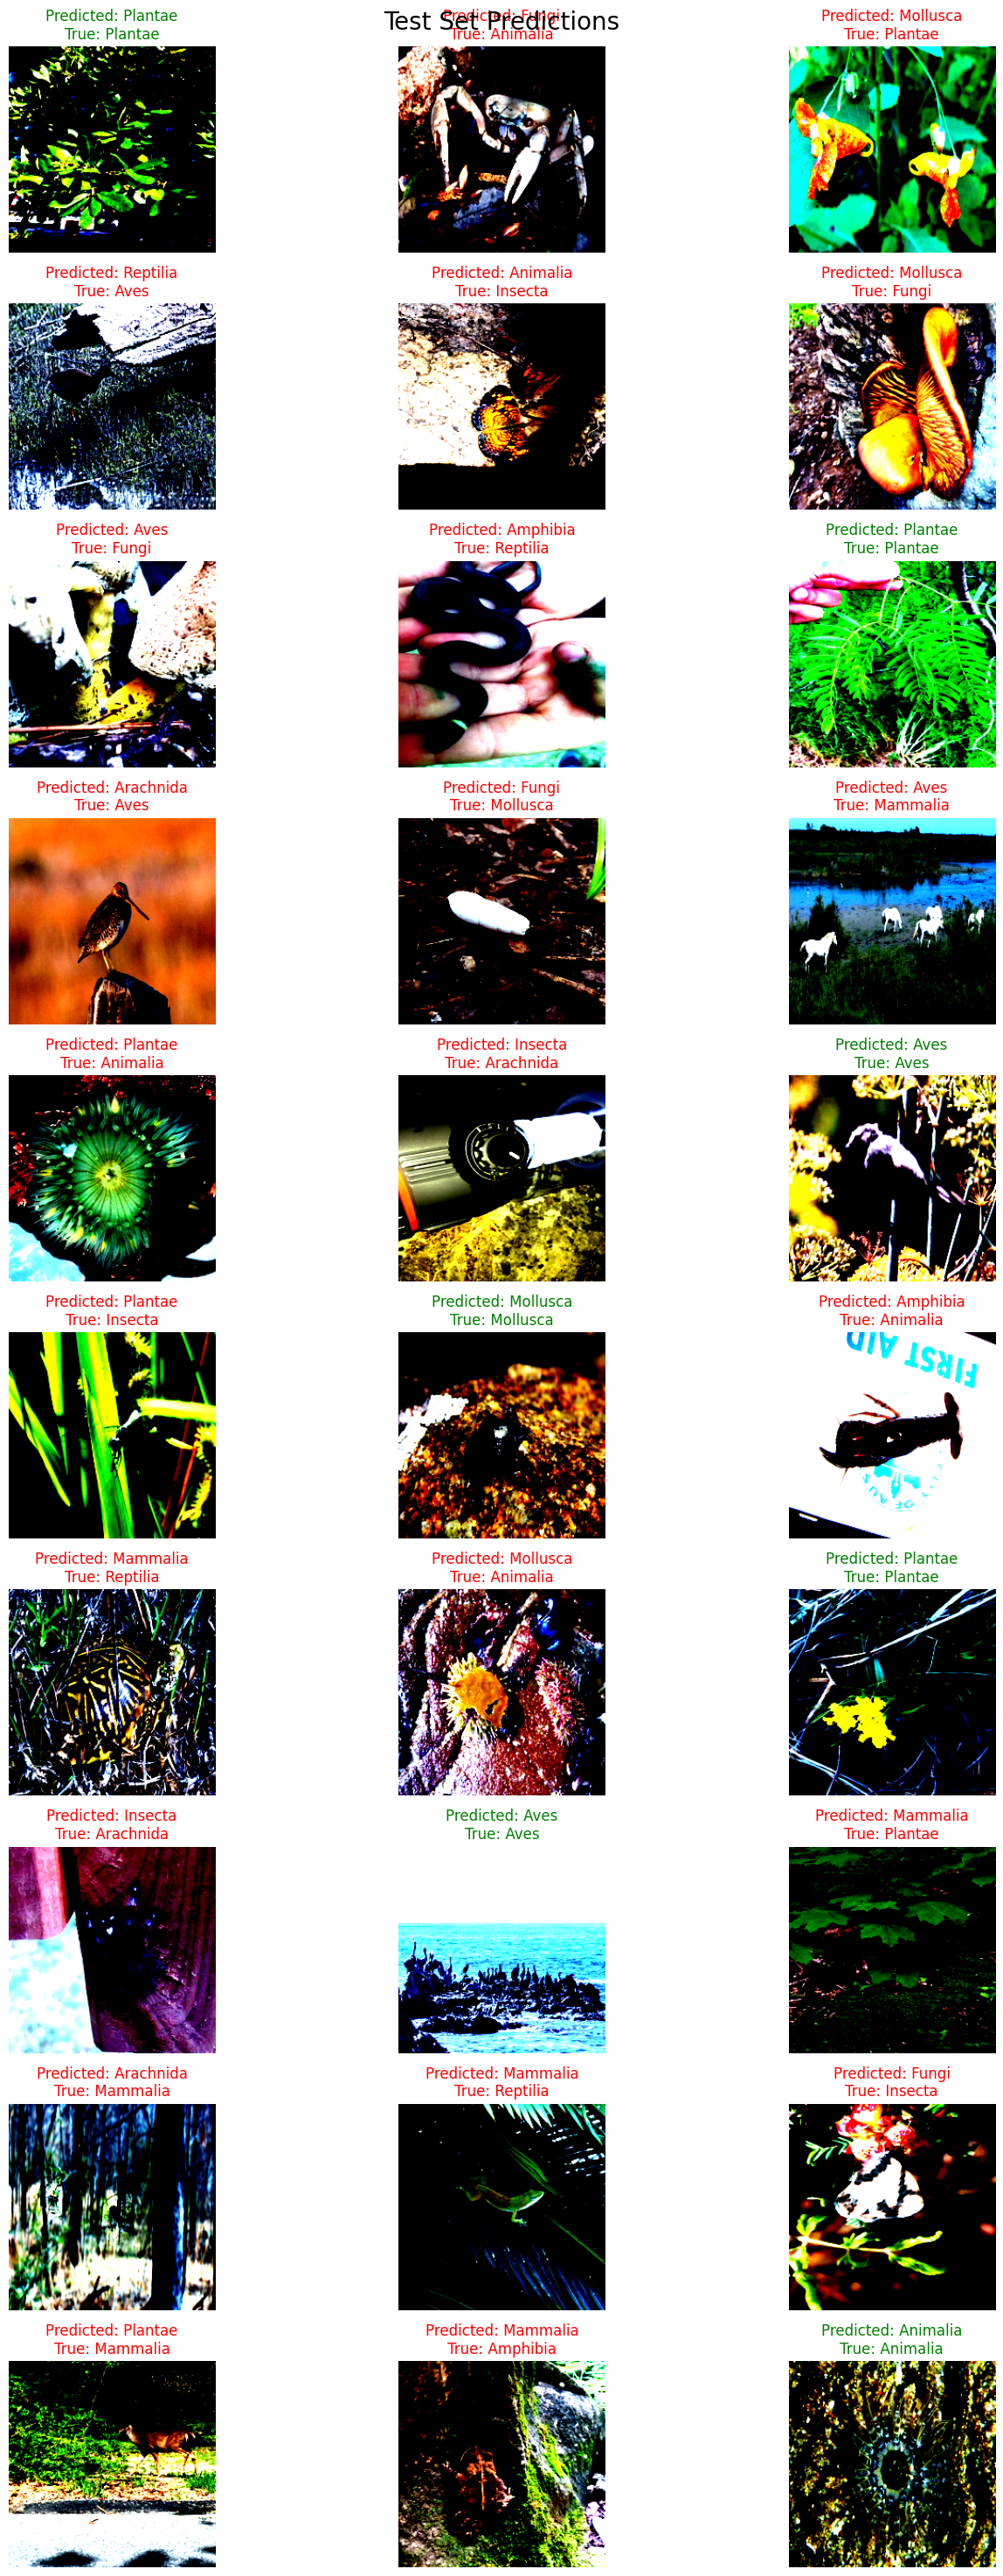

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import wandb
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Define the CNN model (same as before)
class FlexibleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10,
                        conv_filters=[16, 32, 64, 128, 256],
                        conv_kernel_size=3,
                        conv_activation=nn.ReLU(),
                        use_batchnorm=False,
                        dropout_rate=0.0,
                        dense_neurons=128,
                        dense_activation=nn.ReLU()):
        super(FlexibleCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        if isinstance(conv_kernel_size, int):
            conv_kernel_size = [conv_kernel_size] * 5
        elif len(conv_kernel_size) != 5:
            raise ValueError("conv_kernel_size must be an integer or a list of 5 integers.")

        in_c = in_channels
        for i in range(5):
            out_c = conv_filters[i]
            kernel_size = conv_kernel_size[i]
            layers = [nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=kernel_size // 2)]
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(conv_activation)
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            if dropout_rate > 0 and i < 4:
                layers.append(nn.Dropout(dropout_rate))
            self.conv_layers.extend(layers)
            in_c = out_c

        self._to_linear = None
        self._determine_linear_input_size((1, in_channels, 224, 224))

        self.dense1 = nn.Linear(self._to_linear, dense_neurons)
        self.dense_activation = dense_activation
        if dropout_rate > 0:
            self.dropout_dense = nn.Dropout(dropout_rate)
        else:
            self.dropout_dense = nn.Identity()
        self.fc = nn.Linear(dense_neurons, num_classes)

    def _determine_linear_input_size(self, input_shape):
        x = torch.randn(input_shape)
        self.eval()
        with torch.no_grad():
            for layer in self.conv_layers:
                x = layer(x)
            self._to_linear = x.view(x.size(0), -1).shape[1]
        self.train()

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_dense(x)
        x = self.dense1(x)
        x = self.dense_activation(x)
        x = self.fc(x)
        return x

def load_data(data_dir, batch_size=32, test_split=0.1, seed=42, augment=False): # Added augment parameter
    """
    Loads and preprocesses the iNaturalist 12K dataset, splitting it into training and testing sets.
    Args:
        data_dir (str): Path to the directory containing the dataset.
        batch_size (int): Batch size for the DataLoaders.
        test_split (float): The proportion of the data to use for the test set.
        seed (int): Random seed for reproducibility.
        augment (bool): Flag to enable data augmentation.  Added this!
    Returns:
        tuple: (train_loader, test_loader, class_names)
    """
    if augment: #  Use augment parameter
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    num_samples = len(full_dataset)
    test_size = int(test_split * num_samples)
    train_size = num_samples - test_size

    generator = torch.Generator().manual_seed(seed)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)

    num_cpu = os.cpu_count()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpu)
    test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=num_cpu)

    return train_loader, test_loader, full_dataset.classes

def evaluate(model, loader, device, criterion, class_names, dataset_name="Validation"): # Added class_names
    """
    Evaluates the model on the given dataloader.
    Args:
        model (nn.Module): The PyTorch model to evaluate.
        loader (DataLoader): The DataLoader for the dataset.
        device (torch.device): The device to use (CPU or GPU).
        criterion (nn.Module): The loss function.
        class_names (list): List of class names.  Added this!
        dataset_name (str): Name of the dataset being evaluated
    Returns:
        tuple: (loss, accuracy)
    """
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print true and predicted labels for each batch
            # for i in range(labels.size(0)):
            #     true_label = class_names[labels[i]]
            #     pred_label = class_names[predicted[i]]
            #     print(f"  Image {total - labels.size(0) + i + 1}: True: {true_label}, Predicted: {pred_label}")

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    print(f'{dataset_name} Loss: {epoch_loss:.4f} {dataset_name} Accuracy: {epoch_accuracy:.4f}')
    return epoch_loss, epoch_accuracy

def train_and_test(best_config, train_dir, test_dir):
    """
    Loads the training and testing data, trains the model with the best hyperparameters,
    and evaluates it on the test set.  Logs results to Wandb.
    Args:
        best_config (dict): The dictionary containing the best hyperparameters found by Wandb Sweep.
        train_dir (str): Path to the directory containing the training dataset.
        test_dir (str): Path to the directory containing the testing dataset.
    """
    wandb.init(project="inaturalist-cnn") #  "final_run"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the data
    train_loader, test_loader, class_names = load_data(train_dir, batch_size=best_config['batch_size'], augment=best_config['data_augmentation']) # Pass augment
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")


    # Instantiate the model with the best hyperparameters
    conv_filter_config = []
    if best_config['filter_organisation'] == 'same':
        conv_filter_config = [best_config['num_filters']] * 5
    elif best_config['filter_organisation'] == 'doubling':
        base_filters = best_config['num_filters']
        conv_filter_config = [base_filters * (2**i) for i in range(5)]
    elif best_config['filter_organisation'] == 'halving':
        base_filters = best_config['num_filters'] * (2**4)
        conv_filter_config = [int(base_filters / (2**i)) for i in range(5)]
    elif best_config['filter_organisation'] == 'custom':
        conv_filter_config = [best_config['num_filters_layer1'], best_config['num_filters_layer2'],
                                    best_config['num_filters_layer3'], best_config['num_filters_layer4'],
                                    best_config['num_filters_layer5']]
    else:
        raise ValueError(f"Invalid filter organisation: {best_config['filter_organisation']}")

    activation_map = {'ReLU': nn.ReLU(), 'GELU': nn.GELU(), 'SiLU': nn.SiLU(), 'Mish': nn.Mish()}
    conv_act = activation_map.get(best_config['conv_activation'], nn.ReLU())
    dense_act = activation_map.get(best_config['dense_activation'], nn.ReLU())

    model = FlexibleCNN(in_channels=3, num_classes=num_classes,
                     conv_filters=conv_filter_config,
                     conv_kernel_size=3,
                     conv_activation=conv_act,
                     use_batchnorm=best_config['batch_norm'],
                     dropout_rate=best_config['dropout'],
                     dense_neurons=best_config['dense_neurons'],
                     dense_activation=dense_act).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'], weight_decay=best_config['weight_decay'])

    # Train on the full training set
    print("Training on the full training set...")
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0
    for epoch in range(best_config['epochs']): # Explicitly loop over epochs
        print(f"Epoch {epoch+1}/{best_config['epochs']}") # Add this line
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = total_train_loss / total_train
        train_accuracy = correct_train / total_train
        print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'epoch': epoch})

    print(f"Finished Training.  Final Training Loss: {train_loss:.4f}, Final Training Accuracy: {train_accuracy:.4f}")


    # Evaluate on the test set
    print("Evaluating on the test set...")
    test_loss, test_accuracy = evaluate(model, test_loader, device, criterion, class_names, dataset_name="Test") # Pass class_names
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy})

    wandb.finish()
    return model # Return the trained model

def visualize_predictions(model, test_loader, class_names, device, num_images=30):
    """
    Visualizes a grid of images from the test set with their predicted and true labels.
    Args:
        model (nn.Module): The trained PyTorch model.
        loader (DataLoader): The DataLoader for the test set.
        class_names (list): A list of class names.
        device (torch.device): The device to use (CPU or GPU).
        num_images (int): The number of images to visualize.  Must be a multiple of 3.
    """
    model.eval()
    images, labels = next(iter(test_loader)) # Get a batch of images
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    fig = plt.figure(figsize=(15, 30))  # Adjust figure size as needed.
    fig.suptitle("Test Set Predictions", fontsize=20)
    for i in range(num_images):
        plt.subplot(10, 3, i + 1)  # Grid of 10 rows, 3 columns
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())  # Convert to HWC and to numpy
        plt.axis('off')
        plt.title(f"Predicted: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}",
                  color=("green" if predicted[i] == labels[i] else "red")) # Color-code correct/incorrect
    plt.tight_layout() # Adjust layout so titles don't overlap
    plt.show()

if __name__ == '__main__':
    #  dictionary containing the best hyperparameters found by Wandb Sweep.
    best_config = {
        'num_filters': 32,
        'filter_organisation': 'same',
        'conv_activation': 'GELU',
        'data_augmentation': True, # Set to True to enable augmentation
        'batch_norm': True,
        'dropout': 0.3,
        'learning_rate': 0.0002,
        'epochs': 10,
        'batch_size': 64,
        'dense_neurons': 64,
        'weight_decay': 0.002
    }

    train_dir = '/content/train'  #  train dataset path
    test_dir = '/content/test'
    # Load the test data
    _, test_loader, class_names = load_data(test_dir, batch_size=best_config['batch_size'], augment=False) # Keep augment=False for test loader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Train the model
    trained_model = train_and_test(best_config, train_dir, test_dir) # Get the trained model

    # Visualize predictions on the test set
    visualize_predictions(trained_model, test_loader, class_names, device) # Pass the trained model

In [ ]:
torch.save(trained_model.state_dict(), "/content/drive/MyDrive/best_flexible_cnn_new.pth")
print("Model saved as best_flexible_cnn_new.pth")

Model saved as best_flexible_cnn_new.pth


The above blocks show the performance of the best CNN model and is saved too!